In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pystan
from fbprophet import Prophet

In [9]:
from sklearn.pipeline import make_pipeline

# get data

In [56]:
url = 'https://raw.githubusercontent.com/Schmidt8181/ThinkfulCapstone/master/data/Food_price_indices_data_jul.csv'
food_data = pd.read_csv(url)
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1/1990,108.7,112.3,94.3,106.4,73.0,201.5
1,2/1990,109.9,117.7,91.9,104.0,72.5,207.9
2,3/1990,107.9,119.6,73.6,102.1,74.6,218.0
3,4/1990,114.2,131.0,85.2,105.1,71.8,216.3
4,5/1990,111.2,130.5,70.0,105.3,74.4,207.2


In [49]:
food_data.tail()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
337,2/2018,171.4,170.3,191.1,161.3,158.0,192.4
338,3/2018,173.2,171.0,197.4,165.4,156.8,185.5
339,4/2018,174.0,170.4,204.1,168.5,154.6,176.1
340,5/2018,176.1,169.3,215.2,172.6,150.6,175.3
341,6/2018,173.7,169.8,213.2,166.2,146.1,177.4


# clean the data

In [5]:
food_data.isnull().any()

Date                   False
Food Price Index       False
Meat Price Index       False
Dairy Price Index      False
Cereals Price Index    False
Oils Price Index       False
Sugar Price Index      False
dtype: bool

In [10]:
# reindex data so we can get dates on our plots, hooray!
indexed_food = food_data.set_index(['Date'])

# explore the data
don't forget that the data is on a scale of 2002-2004 = 100.0

In [14]:
indexed_food.describe()

,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,140.308772,135.943860,140.497661,137.465789,134.756140,182.055848
std,43.280898,30.528729,57.171255,50.422226,53.183568,74.248813
min,85.100000,84.500000,66.100000,80.200000,57.100000,72.900000
25%,105.450000,113.950000,93.425000,97.850000,90.950000,127.850000
50%,122.500000,128.850000,117.200000,113.400000,122.950000,166.850000
75%,173.125000,162.075000,189.100000,165.850000,166.550000,218.950000
max,240.100000,212.000000,275.400000,267.700000,286.500000,420.200000


/anaconda/lib/python3.6/site-packages/seaborn/palettes.py:727: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


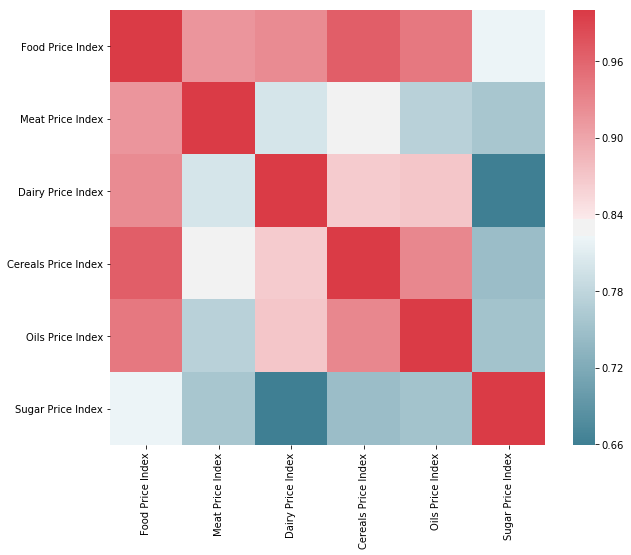

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = indexed_food.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


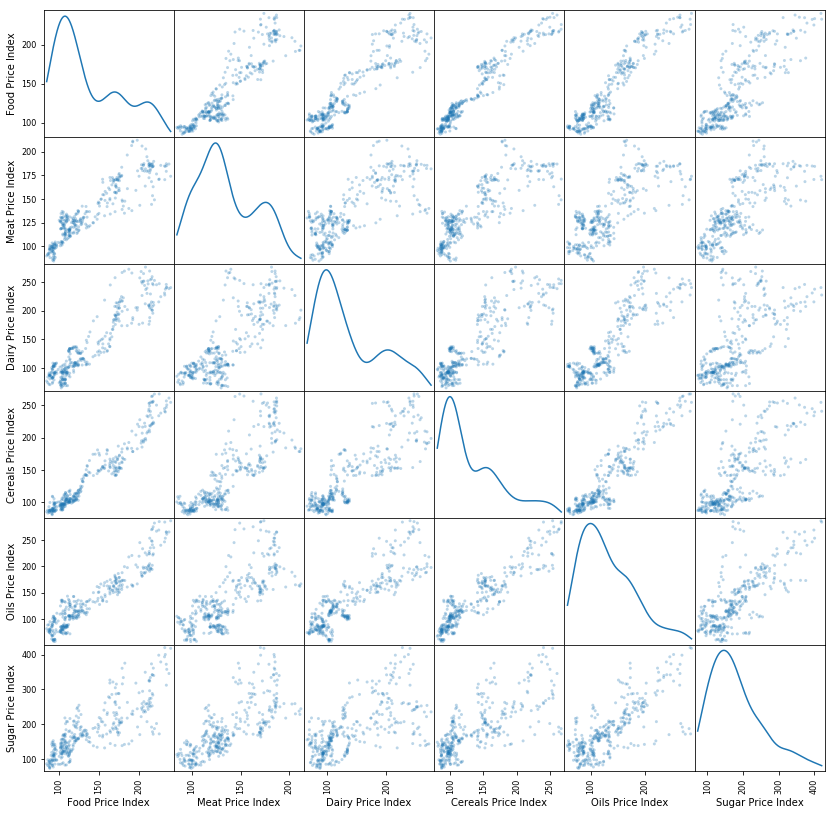

In [16]:
pd.plotting.scatter_matrix(indexed_food, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [69]:
# checking for collinearity, thinking the 'Food Price Index' is built from the other indices
food_corr = np.corrcoef(indexed_food, rowvar=False)
eig_val, eig_vec = np.linalg.eig(food_corr)
eig_val

array([5.19958633e+00, 3.76526687e-01, 2.32175711e-01, 4.68592441e-07,
       1.32968604e-01, 5.87421979e-02])

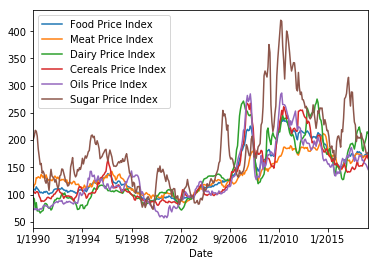

In [40]:
indexed_food.plot()
plt.show()

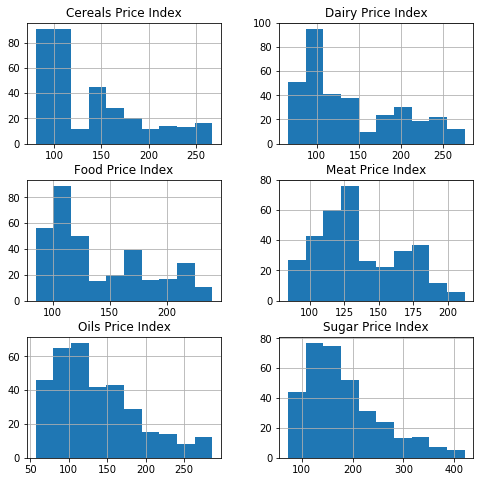

In [34]:
indexed_food.hist(figsize=(8,8))
plt.show()

# feature engineering

In [21]:
from statsmodels.tsa.stattools import adfuller


/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
df_diff = indexed_food.diff()

In [18]:
df_diff.head()

,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
Date,,,,,,
1/1990,NaN,NaN,NaN,NaN,NaN,NaN
2/1990,1.2,5.4,-2.4,-2.4,-0.5,6.4
3/1990,-2.0,1.9,-18.3,-1.9,2.1,10.1
4/1990,6.3,11.4,11.6,3.0,-2.8,-1.7
5/1990,-3.0,-0.5,-15.2,0.2,2.6,-9.1


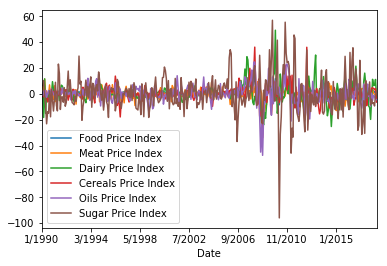

In [19]:
df_diff.plot()
plt.show()

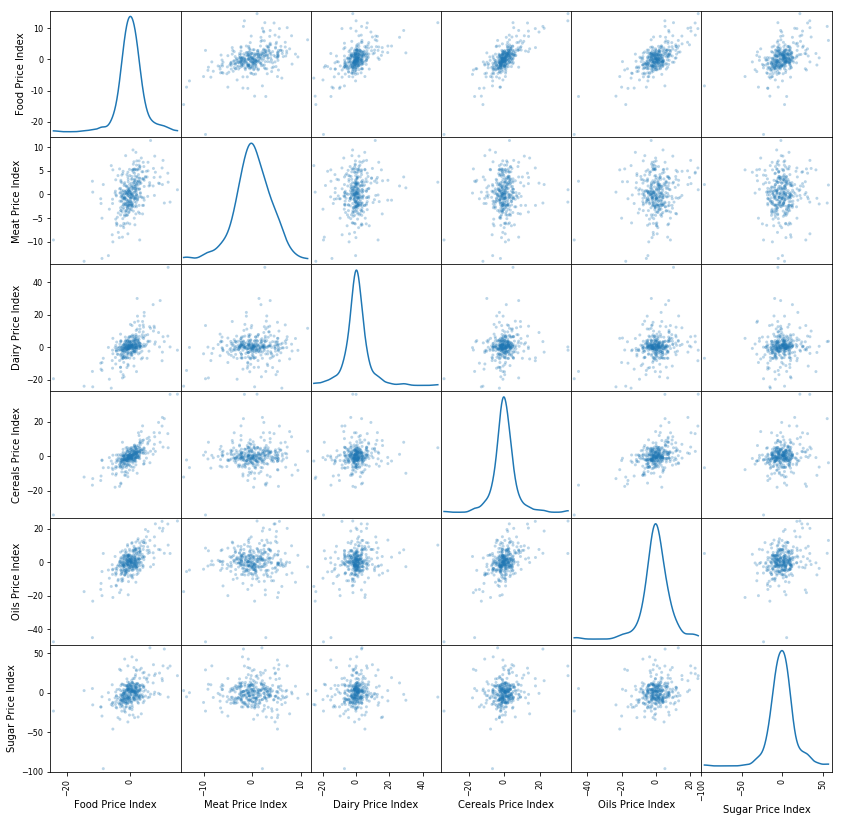

In [47]:
pd.plotting.scatter_matrix(df_diff, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [23]:
def test_fuller(df):
    result = adfuller(df[1:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [24]:
test_fuller(df_diff['Meat Price Index'])

ADF Statistic: -5.277695
p-value: 0.000006
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [25]:
test_fuller(df_diff['Cereals Price Index'])

ADF Statistic: -4.911983
p-value: 0.000033
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [26]:
test_fuller(df_diff['Dairy Price Index'])

ADF Statistic: -6.427264
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [27]:
test_fuller(df_diff['Oils Price Index'])

ADF Statistic: -5.623695
p-value: 0.000001
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [28]:
test_fuller(df_diff['Sugar Price Index'])

ADF Statistic: -12.189071
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


all adfuller tests show that the differenced data is stationary

next step is to split df into different frames for each index? then to label each frame with if the index went up or down

In [38]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


In [60]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [41]:
year_diff_df = pd.DataFrame()
year_diff_df['Sugar Price Index'] = difference(indexed_food['Sugar Price Index'], interval=12)
year_diff_df['Oils Price Index'] = difference(indexed_food['Oils Price Index'], interval=12)
year_diff_df['Dairy Price Index'] = difference(indexed_food['Dairy Price Index'], interval=12)
year_diff_df['Cereals Price Index'] = difference(indexed_food['Cereals Price Index'], interval=12)
year_diff_df['Meat Price Index'] = difference(indexed_food['Meat Price Index'], interval=12)

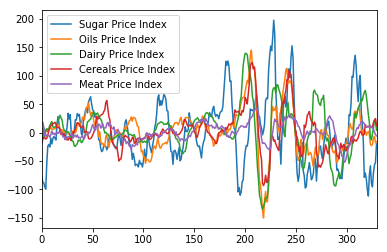

In [43]:
year_diff_df.plot()
plt.show()

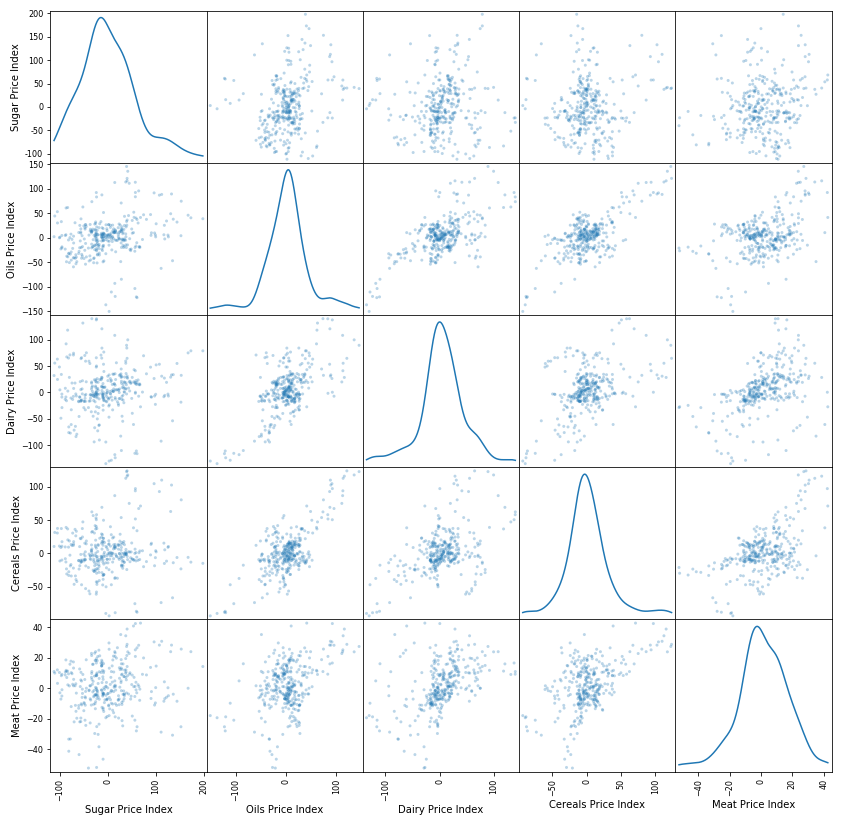

In [44]:
pd.plotting.scatter_matrix(year_diff_df, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [149]:
food_data['Date'] = pd.to_datetime(food_data['Date'])
food_data['Year'], food_data['Month'] = food_data['Date'].dt.year, food_data['Date'].dt.month

food_data['Season_NH'] = food_data['Date'].apply(lambda dt: (dt.month%12 + 3)//3)

In [155]:
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Meat_diff,Dairy_diff,Cereals_diff,Oils_diff,Sugar_diff,Year,Month,Season_NH
0,1990-01-01,108.7,112.3,94.3,106.4,73.0,201.5,NaN,NaN,NaN,NaN,NaN,1990,1,1
1,1990-02-01,109.9,117.7,91.9,104.0,72.5,207.9,5.4,-2.4,-2.4,-0.5,6.4,1990,2,1
2,1990-03-01,107.9,119.6,73.6,102.1,74.6,218.0,1.9,-18.3,-1.9,2.1,10.1,1990,3,2
3,1990-04-01,114.2,131.0,85.2,105.1,71.8,216.3,11.4,11.6,3.0,-2.8,-1.7,1990,4,2
4,1990-05-01,111.2,130.5,70.0,105.3,74.4,207.2,-0.5,-15.2,0.2,2.6,-9.1,1990,5,2


# Time series analysis

In [58]:
split_point = len(df_diff) - 70
dataset, validation = df_diff[1:split_point], df_diff[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#dataset.to_csv('dataset.csv')
#validation.to_csv('validation.csv')

Dataset 271, Validation 70


In [59]:
dataset.head()

,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
Date,,,,,,
2/1990,1.2,5.4,-2.4,-2.4,-0.5,6.4
3/1990,-2.0,1.9,-18.3,-1.9,2.1,10.1
4/1990,6.3,11.4,11.6,3.0,-2.8,-1.7
5/1990,-3.0,-0.5,-15.2,0.2,2.6,-9.1
6/1990,-1.9,2.2,0.0,-2.2,-2.7,-23.2


In [61]:
# fit model
model = ARIMA(dataset['Meat Price Index'], order=(7,0,1))
model_fit = model.fit(disp=0)
# one-step out of sample forecast
start_index = len(dataset)
end_index = len(dataset)
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
forecast = inverse_difference(dataset['Meat Price Index'], forecast, 12)
print('Forecast: %f' % forecast)


NameError: name 'ARIMA' is not defined

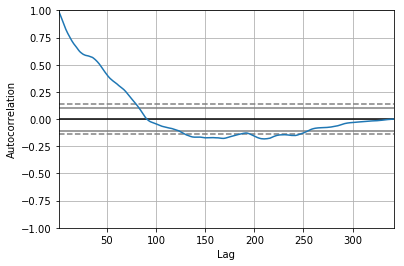

In [162]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(indexed_food)
plt.show()

That looks like the first 80-ish lags are very significant. Lets split the dataset in half and see what we get then. The data starts in 1990 and doesn't become volitile until 2007(ish).

In [169]:
UpTo2006 = indexed_food[:192]
After2005 = indexed_food[192:]

In [175]:
indexed_food.head()

,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
Date,,,,,,
1/1990,108.7,112.3,94.3,106.4,73.0,201.5
2/1990,109.9,117.7,91.9,104.0,72.5,207.9
3/1990,107.9,119.6,73.6,102.1,74.6,218.0
4/1990,114.2,131.0,85.2,105.1,71.8,216.3
5/1990,111.2,130.5,70.0,105.3,74.4,207.2


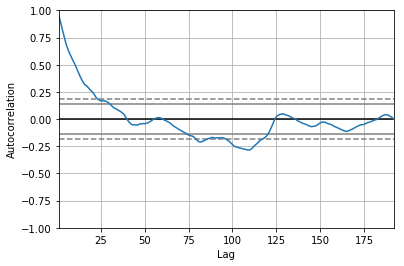

In [179]:
autocorrelation_plot(UpTo2006['Sugar Price Index'])
plt.show()

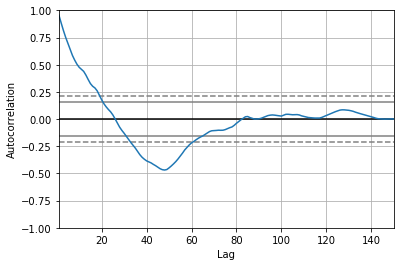

In [180]:
autocorrelation_plot(After2005['Sugar Price Index'])
plt.show()

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARIMA Model Results                              
Dep. Variable:     D.Sugar Price Index   No. Observations:                  149
Model:                 ARIMA(25, 1, 0)   Log Likelihood                -634.488
Method:                        css-mle   S.D. of innovations             16.989
Date:                 Thu, 09 Aug 2018   AIC                           1322.976
Time:                         21:10:36   BIC                           1404.083
Sample:                     02-01-2006   HQIC                          1355.929
                          - 06-01-2018                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.1486      1.459     -0.102      0.919      -3.009       2.712
ar.L1.D.Sugar Price Index      0.3862      0.082      4.694      0.000     

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


NameError: name 'pyplot' is not defined

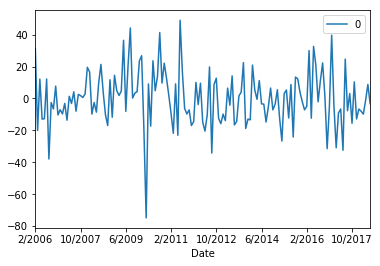

In [182]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(After2005['Sugar Price Index'], order=(25,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [183]:
model2 = ARIMA(After2005['Sugar Price Index'], order=(25,1,12))
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())
# plot residual errors
residuals2 = pd.DataFrame(model_fit2.resid)
residuals2.plot()
plt.show()
residuals2.plot(kind='kde')
plt.show()
print(residuals2.describe())

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergence

KeyboardInterrupt: 

In [214]:
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Meat_diff,Dairy_diff,Cereals_diff,Oils_diff,Sugar_diff,Year,Month,Season_NH
0,1990-01-01,108.7,112.3,94.3,106.4,73.0,201.5,NaN,NaN,NaN,NaN,NaN,1990,1,1
1,1990-02-01,109.9,117.7,91.9,104.0,72.5,207.9,5.4,-2.4,-2.4,-0.5,6.4,1990,2,1
2,1990-03-01,107.9,119.6,73.6,102.1,74.6,218.0,1.9,-18.3,-1.9,2.1,10.1,1990,3,2
3,1990-04-01,114.2,131.0,85.2,105.1,71.8,216.3,11.4,11.6,3.0,-2.8,-1.7,1990,4,2
4,1990-05-01,111.2,130.5,70.0,105.3,74.4,207.2,-0.5,-15.2,0.2,2.6,-9.1,1990,5,2


# Forecasting

In [228]:
sugar_df = pd.DataFrame()
sugar_df['ds'] = food_data.Date # would not take 'Date' as column name
sugar_df['y'] = food_data['Sugar Price Index'] # would not take 'sugar_diff' as column name
m = Prophet(seasonality_mode='multiplicative').fit(sugar_df)
# the example only had 2 columns so lets do that with the Sugars Index


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [229]:
future = m.make_future_dataframe(periods=1826)
future.tail()

,ds
2163,2023-05-28
2164,2023-05-29
2165,2023-05-30
2166,2023-05-31
2167,2023-06-01


In [232]:
forecast = m.predict(future)

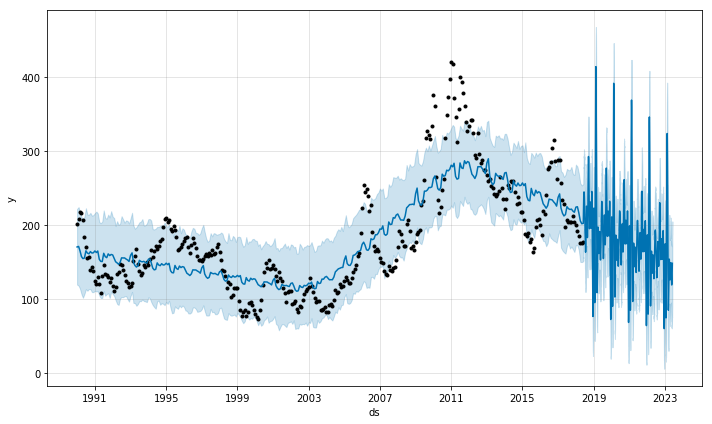

In [233]:
# lets see a plot?
fig1 = m.plot(forecast)

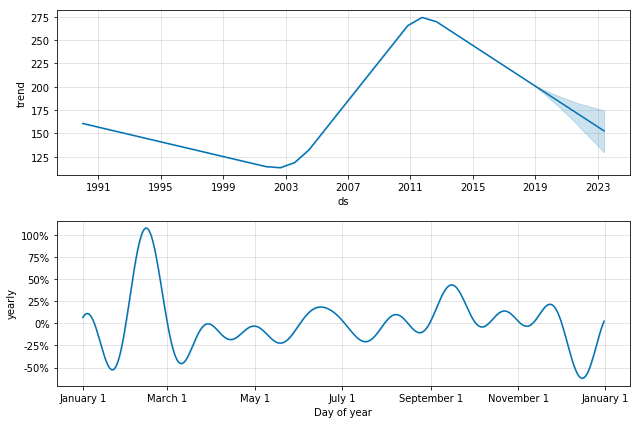

In [234]:
fig2 = m.plot_components(forecast)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


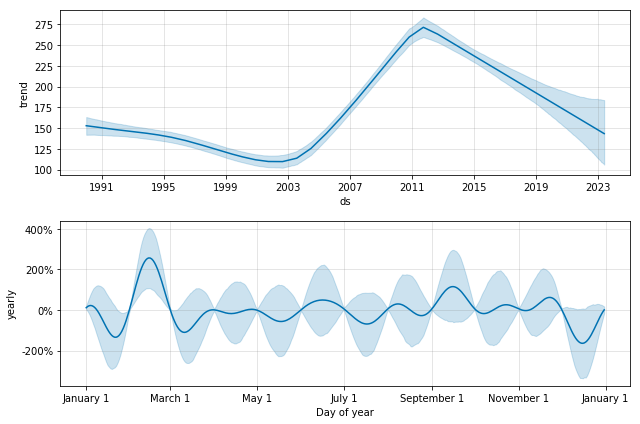

In [235]:
m2 = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(sugar_df)
fcst = m2.predict(future)
fig = m2.plot_components(fcst)

# dashboard code?